### 타이타닉 생존자 예측

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = sns.load_dataset('titanic')
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


##### 1. 데이터 전처리

- Feature selection: 중복 필드 제외

In [3]:
df = df[['survived','pclass','sex','age','sibsp','parch','fare','embarked','who','deck']]
df.tail()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,who,deck
886,0,2,male,27.0,0,0,13.00,S,man,NaN
887,1,1,female,19.0,0,0,30.00,S,woman,B
888,0,3,female,NaN,1,2,23.45,S,woman,NaN
889,1,1,male,26.0,0,0,30.00,C,man,C
890,0,3,male,32.0,0,0,7.75,Q,man,NaN


- 결측치 처리

In [4]:
# 결측치 확인
df.isna().sum()

survived      0
pclass        0
sex           0
age         177
sibsp         0
parch         0
fare          0
embarked      2
who           0
deck        688
dtype: int64

In [5]:
# age는 평균으로 대체
# 단, who column이 결측치가 없으므로 어른은 어른나이 평균, 아동은 아동나이 평균으로 대체
adult = df[df.who.isin(['man','woman'])]
child = df[df.who == 'child']
adult.shape, child.shape

((808, 10), (83, 10))

In [6]:
# 아동은 결측치가 없음
adult.age.isna().sum(), child.age.isna().sum()

(177, 0)

In [7]:
df.age.fillna(adult.age.mean().round(1), inplace=True)
df.tail()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,who,deck
886,0,2,male,27.0,0,0,13.00,S,man,NaN
887,1,1,female,19.0,0,0,30.00,S,woman,B
888,0,3,female,32.8,1,2,23.45,S,woman,NaN
889,1,1,male,26.0,0,0,30.00,C,man,C
890,0,3,male,32.0,0,0,7.75,Q,man,NaN


In [8]:
# embarked 결측치를 최빈값으로 대체
df.embarked.value_counts()

embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [9]:
df.embarked.fillna('S', inplace=True)
df.embarked.isna().sum()

0

In [10]:
# deck 컬럼 삭제(결측치가 너무 많아서), who 컬럼도 삭제(age와 중복)
df.drop(columns=['deck','who'], inplace=True)

In [11]:
df.isna().sum().sum()

0

- 카테고리형 데이터를 숫자로 변환

In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [13]:
df.sex = le.fit_transform(df.sex)
df.embarked = le.fit_transform(df.embarked)
df.tail(3)

,survived,pclass,sex,age,sibsp,parch,fare,embarked
888,0,3,0,32.8,1,2,23.45,2
889,1,1,1,26.0,0,0,30.00,0
890,0,3,1,32.0,0,0,7.75,1


##### 2. 주성분 도출

In [14]:
from sklearn.preprocessing import StandardScaler
titanic_std = StandardScaler().fit_transform(df.iloc[:, 1:].values)

In [15]:
from sklearn.decomposition import PCA
pca = PCA(2)
titanic_pca = pca.fit_transform(titanic_std)

In [16]:
pca.explained_variance_ratio_, sum(pca.explained_variance_ratio_)

(array([0.26432906, 0.24520772]), 0.5095367779956601)

In [17]:
dt = pd.DataFrame(titanic_std, columns=df.columns[1:])
dt['PC1'] = titanic_pca[:, 0]
dt['PC2'] = titanic_pca[:, 1]
dt['target'] = df.survived.values
dt.head()

,pclass,sex,age,sibsp,parch,fare,embarked,PC1,PC2,target
0,0.827377,0.737695,-0.637004,0.432793,-0.473674,-0.502445,0.585954,-1.260268,0.656886,0
1,-1.566107,-1.355574,0.588723,0.432793,-0.473674,0.786845,-1.942303,2.283525,-1.106072,1
2,0.827377,-1.355574,-0.330572,-0.474545,-0.473674,-0.488854,0.585954,-0.678950,0.425341,1
3,-1.566107,-1.355574,0.358899,0.432793,-0.473674,0.420730,0.585954,1.349088,-0.459511,1
4,0.827377,0.737695,0.358899,-0.474545,-0.473674,-0.486337,0.585954,-1.375322,-0.323265,0


##### 3. 시각화

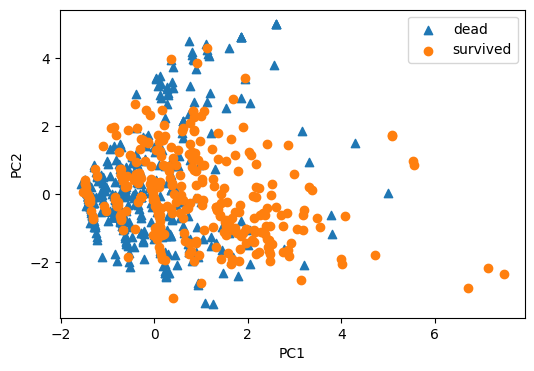

In [18]:
markers = ['^','o']     
plt.figure(figsize=(6,4))
for i, marker in enumerate(markers):
    x_data = dt[dt.target == i]['PC1']
    y_data = dt[dt.target == i]['PC2']
    plt.scatter(x_data, y_data, marker=marker, label='dead' if i == 0 else 'survived')
plt.legend()
plt.xlabel('PC1'), plt.ylabel('PC2')
plt.show()

##### 4. PCA 전후 분류 비교

In [19]:
y = df.survived.values

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    titanic_std, y, stratify=y, test_size=0.2, random_state=2023
)

In [21]:
from sklearn.linear_model import LogisticRegression
lrc = LogisticRegression(random_state=2023)
lrc.fit(X_train, y_train)
lrc.score(X_test, y_test)

0.7486033519553073

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    titanic_pca, y, stratify=y, test_size=0.2, random_state=2023
)
lrc = LogisticRegression(random_state=2023)
lrc.fit(X_train, y_train)
lrc.score(X_test, y_test)

0.7094972067039106

In [23]:
def pca_accuracy(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=2023
    )
    lrc = LogisticRegression(random_state=2023)
    lrc.fit(X_train, y_train)
    score = lrc.score(X_test, y_test)
    return score

In [24]:
for n in [2, 3, 4, 5, 6]:
    pca = PCA(n_components=n)
    titanic_pca = pca.fit_transform(titanic_std)
    explained = sum(pca.explained_variance_ratio_)
    acc = pca_accuracy(titanic_pca, y)
    print(f'PCA{n}: 설명력-{explained:.4f}, 정확도-{acc:.4f}')

PCA2: 설명력-0.5095, 정확도-0.7095
PCA3: 설명력-0.6492, 정확도-0.7207
PCA4: 설명력-0.7689, 정확도-0.7709
PCA5: 설명력-0.8673, 정확도-0.7765
PCA6: 설명력-0.9472, 정확도-0.7821
